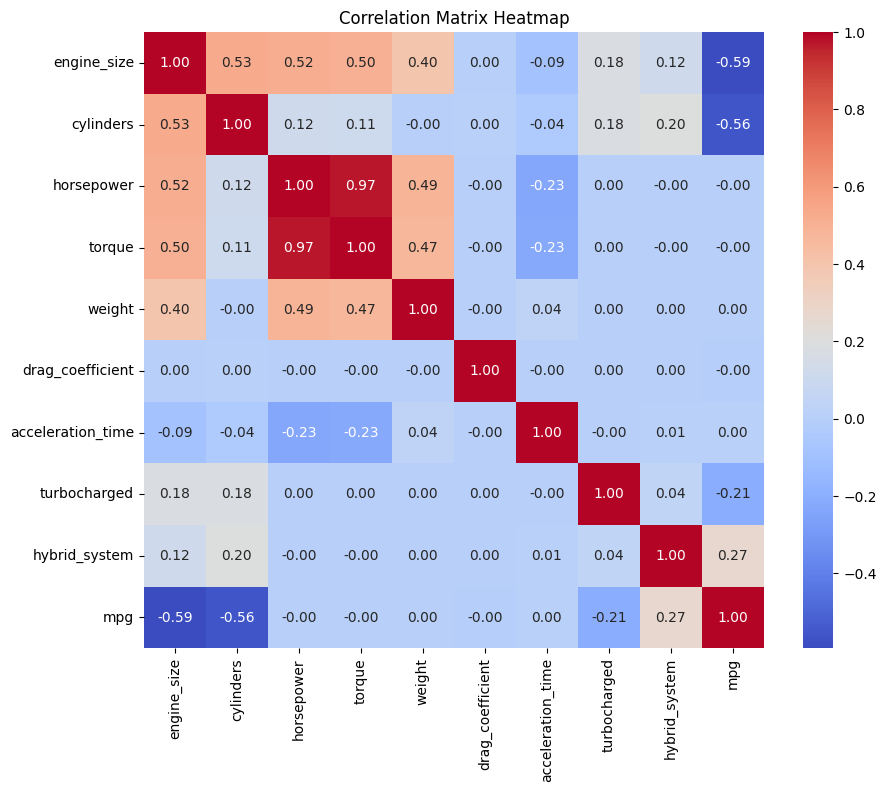

Missing values in X_train before cleaning:
engine_size          0
cylinders            0
horsepower           0
torque               0
weight               0
drag_coefficient     0
acceleration_time    0
power_to_weight      0
torque_to_weight     0
engine_efficiency    0
transmission         0
drivetrain           0
tire_type            0
fuel_type            0
fuel_injection       0
turbocharged         0
hybrid_system        0
dtype: int64
Missing values in X_train after cleaning:
engine_size          0
cylinders            0
horsepower           0
torque               0
weight               0
drag_coefficient     0
acceleration_time    0
power_to_weight      0
torque_to_weight     0
engine_efficiency    0
transmission         0
drivetrain           0
tire_type            0
fuel_type            0
fuel_injection       0
turbocharged         0
hybrid_system        0
dtype: int64
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight'

/tmp/ipython-input-12-1787402.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


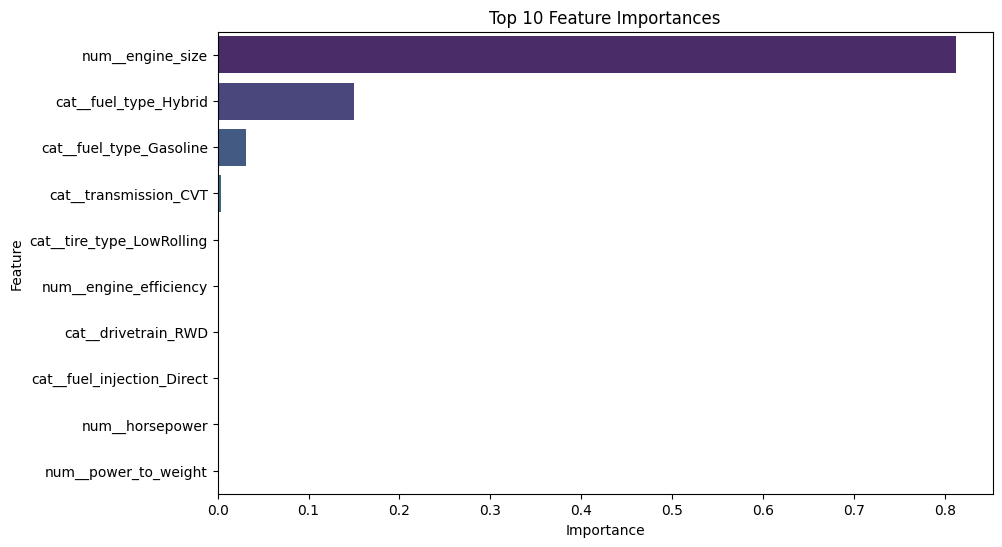

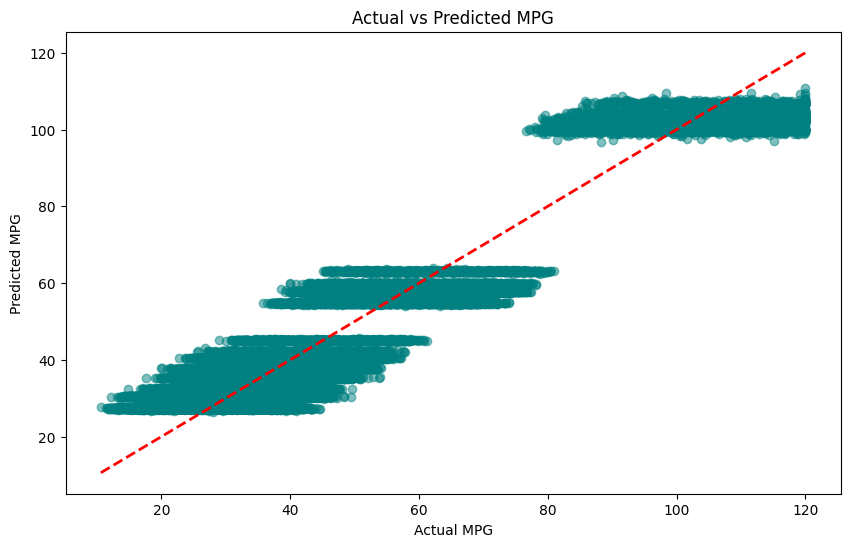

Model saved as 'xgboost_mpg_model.pkl'


In [ ]:
# train_model_colab.py
# === Standard Libraries ===

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Upload CSV File
df = pd.read_csv('/content/improved_fuel_efficiency2.csv')

# Ensure inline plots in Colab
%matplotlib inline

# ===============================
# Graph 1: Correlation Matrix & Heatmap for Numerical Features
# ===============================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

# === Feature Engineering ===
df['power_to_weight'] = df['horsepower'] / df['weight']
df['torque_to_weight'] = df['torque'] / df['weight']
df['engine_efficiency'] = df['horsepower'] / df['engine_size'].replace(0, 0.1)

numeric_features = ['engine_size', 'cylinders', 'horsepower', 'torque', 'weight',
                    'drag_coefficient', 'acceleration_time', 'power_to_weight',
                    'torque_to_weight', 'engine_efficiency']
categorical_features = ['transmission', 'drivetrain', 'tire_type', 'fuel_type',
                        'fuel_injection', 'turbocharged', 'hybrid_system']
target = 'mpg'

# === Data Preprocessing Pipeline ===
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# === Split the Data ===
X = df[numeric_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Handle Missing Values ===
print("Missing values in X_train before cleaning:")
print(X_train.isnull().sum())
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]
print("Missing values in X_train after cleaning:")
print(X_train.isnull().sum())

# === Model Pipeline with XGBoost ===
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# === Hyperparameter Grid ===
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__min_child_weight': [1, 3],
    'regressor__subsample': [0.8, 1.0],
}

# === Grid Search ===
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# === Evaluation ===
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Accuracy (R² as percentage): {r2*100:.2f}%")

# === Feature Importance ===
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
importances = best_model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()

# === Actual vs Predicted Plot ===
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Actual vs Predicted MPG')
plt.show()

# === Save Model ===
joblib.dump(best_model, '/content/xgboost_mpg_model.pkl')
print("Model saved as 'xgboost_mpg_model.pkl'")

# === Optional: Download the saved model to your system ===
# files.download('/content/xgboost_mpg_model.pkl')


In [ ]:
# Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")  # ✅ Save
plt.close()

# Top 10 Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.savefig("feature_importance.png")  # ✅ Save
plt.close()

# Actual vs Predicted MPG
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Actual vs Predicted MPG')
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")  # ✅ Save
plt.close()


/tmp/ipython-input-13-309258284.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
joblib.dump(best_model, 'xgboost_mpg_model.pkl')


['xgboost_mpg_model.pkl']

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load model
model = joblib.load("xgboost_mpg_model.pkl")

st.title("🚗 Fuel Efficiency Predictor (MPG)")
st.markdown("Enter the car features to predict fuel efficiency (MPG).")

# User Inputs
with st.form("input_form"):
    engine_size = st.number_input("Engine Size (L)", min_value=0.0, value=2.0)
    cylinders = st.number_input("Cylinders", min_value=1, value=4)
    horsepower = st.number_input("Horsepower", min_value=10.0, value=150.0)
    torque = st.number_input("Torque (lb-ft)", min_value=10.0, value=200.0)
    weight = st.number_input("Weight (lbs)", min_value=500.0, value=3000.0)
    drag_coefficient = st.number_input("Drag Coefficient", min_value=0.2, value=0.3)
    acceleration_time = st.number_input("0-60 mph Time (s)", min_value=1.0, value=8.0)

    transmission = st.selectbox("Transmission", ['Automatic', 'Manual'])
    drivetrain = st.selectbox("Drivetrain", ['FWD', 'RWD', 'AWD'])
    tire_type = st.selectbox("Tire Type", ['All-Season', 'Summer', 'Winter'])
    fuel_type = st.selectbox("Fuel Type", ['Petrol', 'Diesel', 'Electric', 'Hybrid'])
    fuel_injection = st.selectbox("Fuel Injection", ['Direct', 'Port'])
    turbocharged = st.selectbox("Turbocharged", ['Yes', 'No'])
    hybrid_system = st.selectbox("Hybrid System", ['Yes', 'No'])

    submitted = st.form_submit_button("Predict MPG")

# Predict
if submitted:
    df = pd.DataFrame([{
        "engine_size": engine_size,
        "cylinders": cylinders,
        "horsepower": horsepower,
        "torque": torque,
        "weight": weight,
        "drag_coefficient": drag_coefficient,
        "acceleration_time": acceleration_time,
        "power_to_weight": horsepower / weight,
        "torque_to_weight": torque / weight,
        "engine_efficiency": horsepower / (engine_size if engine_size > 0 else 0.1),
        "transmission": transmission,
        "drivetrain": drivetrain,
        "tire_type": tire_type,
        "fuel_type": fuel_type,
        "fuel_injection": fuel_injection,
        "turbocharged": turbocharged,
        "hybrid_system": hybrid_system
    }])

    prediction = model.predict(df)[0]
    st.success(f"🎯 Estimated MPG: **{prediction:.2f}**")

# Charts Section
st.header("📈 Model Visualizations")

with st.expander("Correlation Heatmap"):
    st.image("correlation_heatmap.png", use_column_width=True)

with st.expander("Top 10 Feature Importances"):
    st.image("feature_importance.png", use_column_width=True)

with st.expander("Actual vs Predicted MPG"):
    st.image("actual_vs_predicted.png", use_column_width=True)

st.markdown("---")
st.caption("Powered by XGBoost + Streamlit")


Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Replace with your actual authtoken string
ngrok.set_auth_token("2zpIWNymrWKQwuW5GdzzzDHjjxH_AoiamPkYZLmeG6iZvLLB")


In [ ]:
public_url = ngrok.connect(addr=8501, proto="http", bind_tls=True)
print(f"🚀 App is live at: {public_url}")


🚀 App is live at: NgrokTunnel: "https://8fcb1aeab425.ngrok-free.app" -> "http://localhost:8501"
